In [262]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fftpack import fft
from scipy import signal


Dir = os.getcwd() + '/' # current dir

In [332]:
file_list = os.listdir(Dir+'data/')
file_list = file_list[2:3]

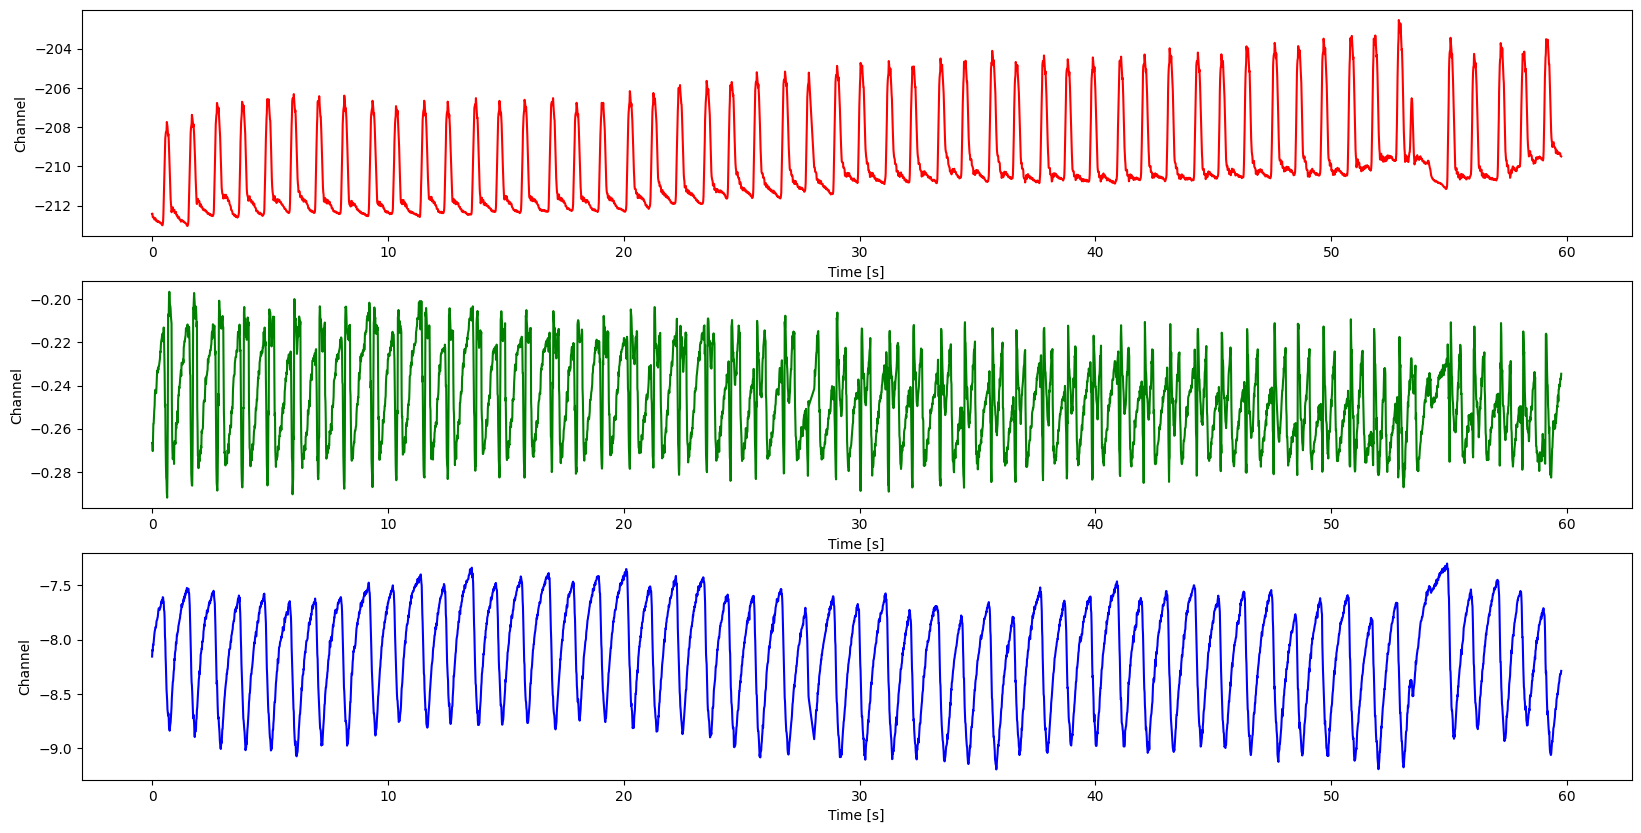

time     0
Red      0
Green    0
Blue     0
dtype: int64


In [333]:
# Plot rGB channels
for file in file_list:
    df = pd.read_csv('data/' + file)
    df.drop('Unnamed: 0', axis=1, inplace=True)
#     print(df.head())
    fig, ax = plt.subplots(3, 1, figsize=(20, 10))

    ax[0].plot(df['time'], df['Red'], 'r-') 
    ax[1].plot(df['time'], df['Green'], 'g-') 
    ax[2].plot(df['time'], df['Blue'], 'b-') 
    
    for i in range(3):
        ax[i].set_xlabel('Time [s]')
        ax[i].set_ylabel('Channel')
#         ax[i].set_xlim(0.5, 5)  # Set the x-axis limits
    plt.show()
    
    print(df.isna().sum())

In [334]:
# Extract time and signal data
t = df.iloc[:, 0].values 
r = df.iloc[:, 1].values  
g = df.iloc[:, 2].values  
b = df.iloc[:, 3].values
fs = 75 # Sampling frequency

In [335]:
# Combining R, G, B to construct PPG
# ppg = (g/r)+(g/b) # GRGB
ppg = g # G channel

# x=df[(df['time']>43.5)&(df['time']<47)]
# x

# Signal Processing Techniques

### Highpass Filtering

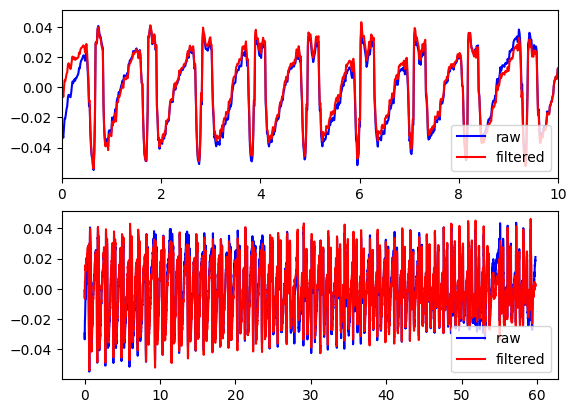

In [336]:
# High-pass cutoff 
hpf_cutoff = .5 # Hz
fs = 75 # Sampling frequency

# Create high-pass filter using Butterworth filter
sos_ppg = signal.butter(4,
                    hpf_cutoff,
                    btype = 'highpass',
                    analog = False,
                    output = 'sos',
                    fs = fs)

#  high-pass filter
ppg_filt = signal.sosfiltfilt(sos_ppg, ppg)

# plot
fig, axs = plt.subplots(2, 1)
axs[0].plot(t, signal.detrend(ppg), color='blue', label='raw')
axs[0].plot(t, ppg_filt, color='red', label='filtered')
axs[0].set_xlim(0, 10)
axs[0].legend()

axs[1].plot(t, signal.detrend(ppg), color='blue', label='raw')
axs[1].plot(t, ppg_filt, color='red', label='filtered')
# axs[1].set_xlim(10, 12)
axs[1].legend()

### Lowpass Filtering

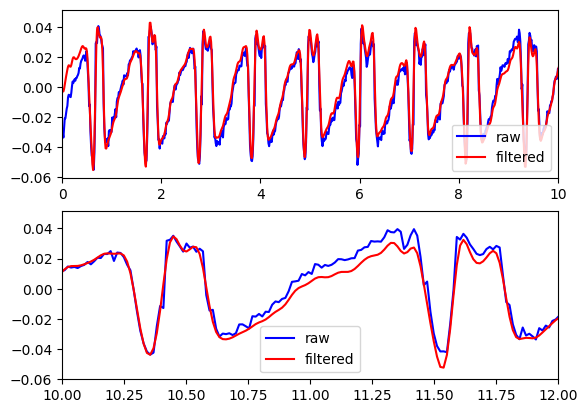

In [337]:
# Low-pass cutoff 
lpf_cutoff = 12 # in Hz
fs = 75

# Create low-pass filter using Butterworth filter
sos_ppg = signal.butter(4,
                    lpf_cutoff,
                    btype = 'lowpass',
                    analog = False,
                    output = 'sos',
                    fs = fs)

#  low-pass filter
ppg_filt = signal.sosfiltfilt(sos_ppg, ppg_filt)

fig, axs = plt.subplots(2, 1)
axs[0].plot(t, signal.detrend(ppg), color='blue', label='raw')
axs[0].plot(t, ppg_filt, color='red', label='filtered')
axs[0].set_xlim(0, 10)
axs[0].legend()

axs[1].plot(t, signal.detrend(ppg), color='blue', label='raw')
axs[1].plot(t, ppg_filt, color='red', label='filtered')
axs[1].set_xlim(10, 12)
axs[1].legend()

In [338]:
import scipy.signal as sp

# Cutoff for bandpass filter
lpf_cutoff = 0.5
hpf_cutoff = 12

sos_ppg = sp.butter(10,
                    [lpf_cutoff, hpf_cutoff],
                    btype = 'bp',
                    analog = False,
                    output = 'sos',
                    fs = fs)

In [339]:
ppg_filt = sp.sosfiltfilt(sos_ppg, ppg_filt)

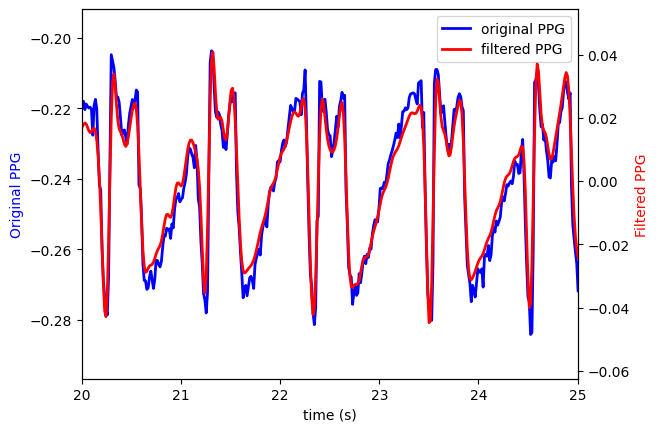

In [340]:
fig, ax = plt.subplots()
t = df['time']

ax.plot(t, ppg, linewidth=2.0, color='blue', label="original PPG")
ax.set_xlabel('Time')
ax.set_ylabel('Original PPG', color='blue')

# Twin axis for the filtered PPG signal
ax2 = ax.twinx()
ax2.plot(t, ppg_filt, linewidth=2.0, color='red', label="filtered PPG")
ax2.set_ylabel('Filtered PPG', color='red')
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc='upper right')

ax.set(xlim=(0, 30))
ax.set_xlabel('time (s)')
ax.set_xlim([20, 25])

plt.show()

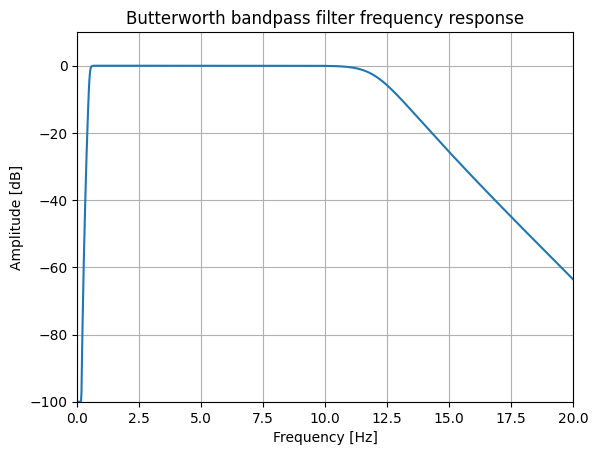

In [341]:
# Butterworth bandpass filter response
w, h = sp.sosfreqz(sos_ppg,
                   2000,
                   fs = fs)
fig, ax = plt.subplots()

ax.plot(w, 20 * np.log10(np.maximum(abs(h), 1e-5)))

ax.set_title('Butterworth bandpass filter frequency response')
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Amplitude [dB]')
ax.set_xlim(0, 20)
ax.set_ylim(-100,10)
ax.grid(which='both',
        axis='both')

### Normalisation

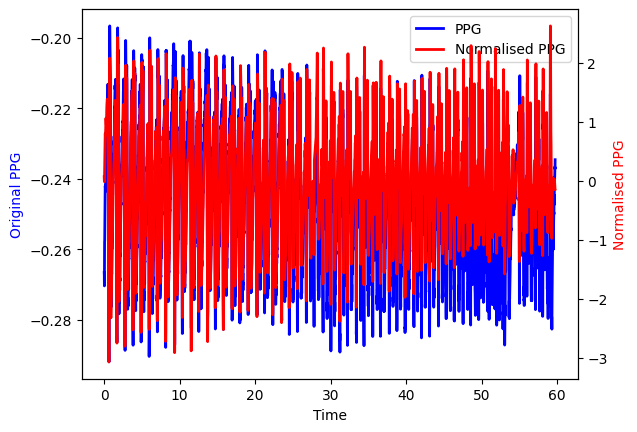

In [342]:

m = np.mean(ppg_filt) # mean of filtered signal
std = np.std(ppg_filt) # standard deviation of filtered signal

ppg_norm = (ppg_filt-m)/std # standardisation of the signal

fig, ax = plt.subplots()

ax.plot(t, ppg, linewidth=2.0, color='blue', label="PPG")
ax.set_xlabel('Time')
ax.set_ylabel('Original PPG', color='blue')

ax2 = ax.twinx()
ax2.plot(t, ppg_norm, linewidth=2.0, color='red', label="Normalised PPG")
ax2.set_ylabel('Normalised PPG', color='red')

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc='upper right')

# ax.set(xlim=(0, 30))
plt.xlabel('time (s)')
# plt.xlim([20, 25])

plt.show()

Text(0.5, 0, 'Time [s]')

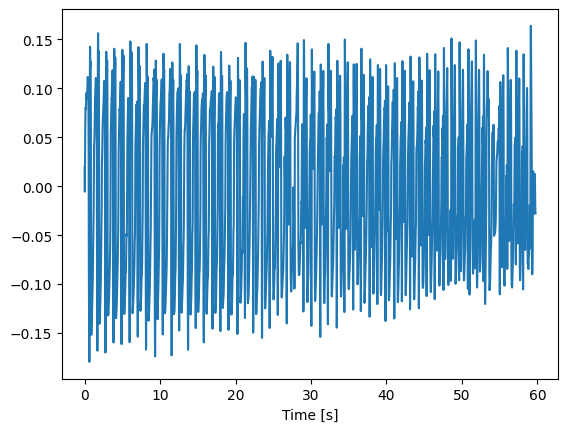

In [343]:

# Parameters for dynamic range compression
compression_factor = .6  # Adjust as needed

# Apply dynamic range compression
compressed_signal = np.sign(ppg_filt) * (np.abs(ppg_filt) ** compression_factor)

plt.plot(t, compressed_signal)
# plt.xlim(10,25)
plt.xlabel('Time [s]')

### Differentiation of PPG Signal

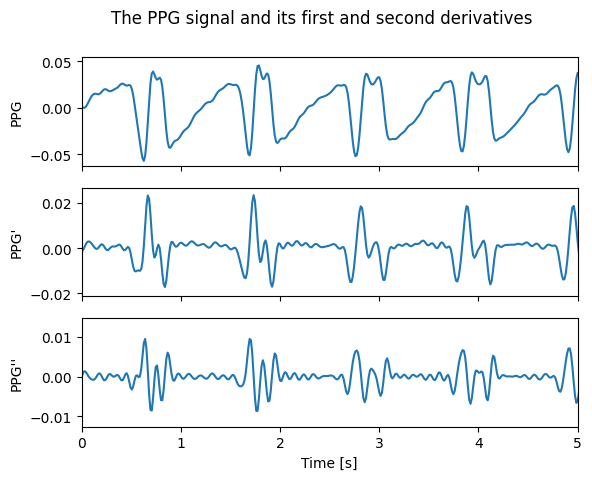

In [344]:
# Savitzky-Golay filtering is used here to calculate derivatives

# Calculate first derivative
d1ppg = sp.savgol_filter(ppg_filt, 9, 5, deriv=1)

# Calculate second derivative
d2ppg = sp.savgol_filter(d1ppg, 9, 5, deriv=1) 

t = np.arange(0, len(ppg_filt))/fs

fig, (ax1,ax2,ax3) = plt.subplots(3, 1, sharex = True, sharey = False)
ax1.plot(t, ppg_filt)
ax1.set(xlabel = '', ylabel = 'PPG')

plt.suptitle('The PPG signal and its first and second derivatives')

ax2.plot(t, d1ppg)
ax2.set(xlabel = '',
        ylabel = 'PPG\'')

ax3.plot(t, d2ppg)
ax3.set(xlabel = 'Time [s]',
        ylabel = 'PPG\'\'')
plt.xlim(0,5)
plt.show()

### Detecting Beats

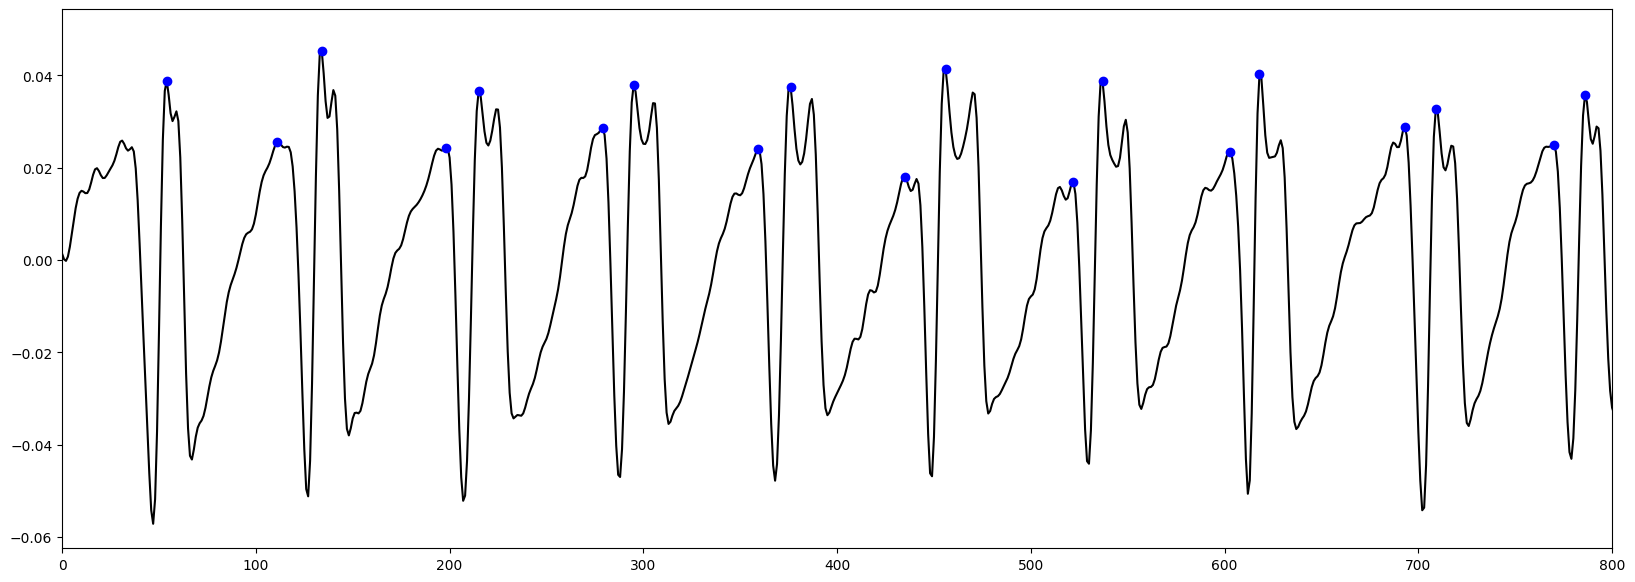

75

In [345]:
from scipy.signal import find_peaks

# ppg_f = ppg_filt[:]

peaks, _ = find_peaks(ppg_filt, prominence=.05)

plt.figure(figsize=(20,7))
plt.plot(ppg_filt, 'k')
plt.plot(peaks, ppg_filt[peaks], 'bo')
plt.xlim(0, 800)
plt.show()
len(peaks)

In [346]:
import numpy as np

def rMSSD(ibi):
    # Compute the rMSSD
    rMSSD = np.sqrt(np.nanmean(np.power(ibi, 2)))

    return rMSSD

def SDNN(ibi):
    sdnn = np.nanstd(ibi)
    return sdnn

def pNN50(ibi):
    pNN50=len(np.where(np.abs(np.diff(ibi))>50)[0])/len(np.diff(ibi))*100
    return pNN50

ibi = np.diff(peaks)

rmssd = rMSSD(ibi)
sdnn = SDNN(ibi)
pnn50 = pNN50(ibi)

print('Number of beats per minute: ', len(peaks))
print('Root mean square of successive differences: ', rmssd)
print('Standard deviation of inter-beat-intervals: ', sdnn)
print('Percentage of successive differences higher than 50ms: ', pnn50)

Number of beats per minute:  75
Root mean square of successive differences:  67.35324386738517
Standard deviation of inter-beat-intervals:  32.19158318190466
Percentage of successive differences higher than 50ms:  24.65753424657534


### PPG Signal in the frequency domain

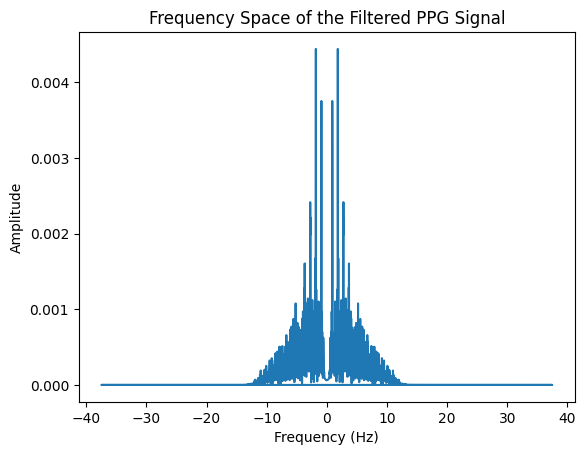

In [347]:
from scipy.fft import fft  

# Compute the FFT
ppg_freq_domain = fft(ppg_filt)

# Frequency bins
n = len(ppg_filt)
frequency_bins = np.fft.fftfreq(n, d=1/fs)

# Normalize the amplitude
ppg_freq_domain = np.abs(ppg_freq_domain) / n

plt.plot(frequency_bins, ppg_freq_domain)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('Frequency Space of the Filtered PPG Signal')
# plt.ylim(0., 0.002)
# plt.xlim(-10, -5)
plt.show()